This notebook takes the models stored last year at `./support_classification/models/` and applies them to the FEVER challenge dataset, in order to test their application in detecting evidence support, and to compare them to the models generated this year with the updated libraries.

Reminder: These models relies on the data from last year, stored in `./support_classification/data/`, which is made in the same way as the second version of our data for the updated pipeline.

In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import torch

HOME = Path('/home/k20036346/')
KERNELGAT_DATA = HOME / 'Repos/KernelGAT/data'
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
MAX_LEN = 400 # As defined when the tokenizer/model was fine-tuned

# Load data and models

We begin with the **DEV** dataset (this section can be changed to look at Train, Eval, and Test datasets too by just changing the loaded dataset path), as this we can score locally. The TEST dataset needs to be sent to CodaLab.

Remember that Train and Dev all have golden data evidence added to it. This guarantees that the right evidence is on the data and *will be considered by the textual entailment model*, but should ideally not give the model any clues as to the right label. We can test this model with the Eval (Dev without golden data) to measure this influence. 

First we retrieve the data with evidence sentences already scored.\
We will combine these with the textual entailment model and get the final evidence+label predictions to get FEVER-scored.

In [2]:
df_with_evidence_scored = []
with open(KERNELGAT_DATA / 'bert_eval_from_fresh_trained_with_batch_size_32.json','r') as f:
    #This was the best performing file on evidence selection
    for line in f:
        df_with_evidence_scored.append(json.loads(line))
df_with_evidence_scored = pd.DataFrame(df_with_evidence_scored)
df_with_evidence_scored

,id,evidence,claim,label
0,91198,"[[Colin_Kaepernick, 6, He remained the team 's...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO
1,194462,"[[Tilda_Swinton, 0, Katherine Matilda `` Tilda...",Tilda Swinton is a vegan.,NOT ENOUGH INFO
2,137334,"[[Soul_Food_-LRB-film-RRB-, 0, Soul Food is a ...",Fox 2000 Pictures released the film Soul Food.,SUPPORTS
3,166626,"[[Anne_Rice, 5, Born in New Orleans , Rice spe...",Anne Rice was born in New Jersey.,NOT ENOUGH INFO
4,111897,"[[Telemundo, 0, Telemundo LRB LSB teleˈmundo R...",Telemundo is a English-language television net...,REFUTES
...,...,...,...,...
19993,8538,"[[Hermit_crab, 0, Hermit crabs are decapod cru...",Hermit crabs are arachnids.,REFUTES
19994,145641,"[[Michael_Hutchence, 17, In 2000 , Yates died ...",Michael Hutchence died on a boat.,REFUTES
19995,87517,"[[Cyclades, 0, The Cyclades LRB LSB ˈsɪklədiːz...",The Cyclades are located to the southeast of G...,SUPPORTS
19996,111816,"[[Theresa_May, 6, From 1977 until 1983 , she w...",Theresa May worked the docks.,NOT ENOUGH INFO


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification

support_prediction_tokenizer = BertTokenizer.from_pretrained(
    './support_classification/models/BERT_tokenizer'
)
support_prediction_model = BertForSequenceClassification.from_pretrained(
    './support_classification/models/BERT_model_hyper'
)

file ./support_classification/models/BERT_tokenizer/config.json not found


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Evaluate and record predictions

In [5]:
df_exploded = df_with_evidence_scored.copy()
df_exploded = df_exploded.explode('evidence')
df_exploded = df_exploded[df_exploded['evidence'].apply(lambda x: type(x)==list)]
df_exploded[['evidence_page','evidence_line','evidence_text','evidence_score']] =\
    pd.DataFrame(df_exploded.evidence.tolist(), index=df_exploded.index)
df_exploded['evidence_score'] = df_exploded['evidence_score'].apply(lambda x: np.max([x,0]))
df_exploded

,id,evidence,claim,label,evidence_page,evidence_line,evidence_text,evidence_score
0,91198,"[Colin_Kaepernick, 6, He remained the team 's ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,6,He remained the team 's starting quarterback f...,0.999393
0,91198,"[Colin_Kaepernick, 0, Colin Rand Kaepernick LR...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,0,Colin Rand Kaepernick LRB LSB ` kæpərnɪk RSB ;...,0.260226
0,91198,"[Colin_Kaepernick, 2, Kaepernick was selected ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,2,Kaepernick was selected by the San Francisco 4...,0.000000
0,91198,"[Colin_Kaepernick, 8, In the following seasons...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,8,"In the following seasons , Kaepernick lost and...",0.000000
0,91198,"[Colin_Kaepernick, 7, During the 2013 season ,...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,7,"During the 2013 season , his first full season...",0.000000
...,...,...,...,...,...,...,...,...
19997,81957,"[Trouble_with_the_Curve, 0, Trouble with the C...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,0,Trouble with the Curve is a 2012 sports drama ...,0.999822
19997,81957,"[Trouble_with_the_Curve, 6, A year after its r...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,6,A year after its release the film became the s...,0.404244
19997,81957,"[Trouble_with_the_Curve, 5, This was Eastwood ...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,5,This was Eastwood 's first acting project sinc...,0.193518
19997,81957,"[Trouble_with_the_Curve, 2, Filming began in M...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,2,"Filming began in March 2012 , and the film was...",0.137360


In [6]:
encoding_inputs = df_exploded.apply(lambda x : [x['claim'],x['evidence_text']], axis=1).to_list()
# This creates a bug list of (claim, evidence) pairs
encodings = support_prediction_tokenizer(
        encoding_inputs,
        max_length= MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
    ).to(DEVICE)

In [7]:
import torch

BATCH_SIZE = 64
support_prediction_model.to(DEVICE)
support_prediction_model.eval()
probs_all = []

total_steps = len(encodings['input_ids'])//BATCH_SIZE + 1
with torch.no_grad():
    for i in range(total_steps):
        print(str(round(100*i/total_steps, 5)).ljust(10,' '),'%', end='\r')
        probs = support_prediction_model(
            input_ids=encodings['input_ids'][i*BATCH_SIZE:(i+1)*BATCH_SIZE],
            attention_mask=encodings['attention_mask'][i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        )
        probs_all = probs_all + torch.softmax(probs.logits,dim=1).tolist()

In [8]:
assert len(probs_all) == df_exploded.shape[0]

In [9]:
df_exploded['predicted_scores'] = probs_all
df_exploded['weighted_scores'] = df_exploded.apply(
    lambda x: x['evidence_score'] * np.array(x['predicted_scores']),
    axis = 1
)

In [10]:
#df_exploded.to_csv('./data/support_data_v2/bert_test_from_fresh_trained_with_batch_size_32_with_support_scores_v2.csv', index=None)

In [11]:
df_exploded#.index

,id,evidence,claim,label,evidence_page,evidence_line,evidence_text,evidence_score,predicted_scores,weighted_scores
0,91198,"[Colin_Kaepernick, 6, He remained the team 's ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,6,He remained the team 's starting quarterback f...,0.999393,"[0.08421030640602112, 0.7625476717948914, 0.15...","[0.08415918959614999, 0.7620847949093843, 0.15..."
0,91198,"[Colin_Kaepernick, 0, Colin Rand Kaepernick LR...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,0,Colin Rand Kaepernick LRB LSB ` kæpərnɪk RSB ;...,0.260226,"[0.4852373003959656, 0.2500787675380707, 0.264...","[0.12627142504928912, 0.06507702999302367, 0.0..."
0,91198,"[Colin_Kaepernick, 2, Kaepernick was selected ...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,2,Kaepernick was selected by the San Francisco 4...,0.000000,"[0.3483318090438843, 0.08309940248727798, 0.56...","[0.0, 0.0, 0.0]"
0,91198,"[Colin_Kaepernick, 8, In the following seasons...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,8,"In the following seasons , Kaepernick lost and...",0.000000,"[0.14210885763168335, 0.11770129948854446, 0.7...","[0.0, 0.0, 0.0]"
0,91198,"[Colin_Kaepernick, 7, During the 2013 season ,...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,Colin_Kaepernick,7,"During the 2013 season , his first full season...",0.000000,"[0.2663722336292267, 0.12940239906311035, 0.60...","[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
19997,81957,"[Trouble_with_the_Curve, 0, Trouble with the C...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,0,Trouble with the Curve is a 2012 sports drama ...,0.999822,"[0.9091009497642517, 0.004442120436578989, 0.0...","[0.9089392026463123, 0.004441330095112134, 0.0..."
19997,81957,"[Trouble_with_the_Curve, 6, A year after its r...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,6,A year after its release the film became the s...,0.404244,"[0.9078987836837769, 0.003407105104997754, 0.0...","[0.3670124246084683, 0.001377301003100198, 0.0..."
19997,81957,"[Trouble_with_the_Curve, 5, This was Eastwood ...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,5,This was Eastwood 's first acting project sinc...,0.193518,"[0.9017382860183716, 0.004299528431147337, 0.0...","[0.17450272207427808, 0.0008320367744213478, 0..."
19997,81957,"[Trouble_with_the_Curve, 2, Filming began in M...",Trouble with the Curve is a television show.,REFUTES,Trouble_with_the_Curve,2,"Filming began in March 2012 , and the film was...",0.137360,"[0.9148448705673218, 0.0036883598659187555, 0....","[0.1256632337549135, 0.0005066336850265835, 0...."


In [12]:
support_classes = ['REFUTES','SUPPORTS','NOT ENOUGH INFO']

methods = ['WEIGHTED_SUM', 'MALON']

if 'WEIGHTED_SUM' in methods:
    predicted_labels = []
    for idx in df_with_evidence_scored.index:
        try:
            summed_scores = df_exploded.weighted_scores.loc[idx].sum()
            predicted_labels.append(support_classes[np.argmax(summed_scores)])
        except KeyError:
            predicted_labels.append('NOT ENOUGH INFO')
            
    df_with_evidence_scored['predicted_label_WEIGHTED_SUM'] = predicted_labels

if 'MALON' in methods:
    '''
     Like (Malon, 2018), the default label is ’NOT ENOUGH INFO’ unless there is any supporting evidence to
     predict the claim label as ’SUPPORTED’. If there is at least one piece of evidence rejecting the claim
     while there is no supporting evidence, the final decision is ’REFUTED’.
     '''
    predicted_labels = []
    for idx in df_with_evidence_scored.index:
        try:
            individual_scores = []
            if type(df_exploded.weighted_scores[idx]) == np.ndarray:
                scores_list = [df_exploded.weighted_scores[idx]]
            else:
                scores_list = df_exploded.weighted_scores[idx].to_list()
            for scores in scores_list:
                if all(scores == [0,0,0]):
                    individual_scores.append(2)
                else:
                    individual_scores.append(np.argmax(scores))
            if 1 not in individual_scores and 0 not in individual_scores:
                predicted_labels.append('NOT ENOUGH INFO')
            elif 1 in individual_scores:
                predicted_labels.append('SUPPORTS')
            elif 0 in individual_scores:
                predicted_labels.append('REFUTES')
        except KeyError:
            predicted_labels.append('NOT ENOUGH INFO')            
    
    df_with_evidence_scored['predicted_label_MALON'] = predicted_labels
            
# A THIRD METHOD BASED ON THRESHOLDS COULD BE PUT HERE IF THESE TWO FAIL TO GIVE US A GOOD QUALITY OF PREDICTION

In [13]:
df_with_evidence_scored

,id,evidence,claim,label,predicted_label_WEIGHTED_SUM,predicted_label_MALON
0,91198,"[[Colin_Kaepernick, 6, He remained the team 's...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,SUPPORTS,SUPPORTS
1,194462,"[[Tilda_Swinton, 0, Katherine Matilda `` Tilda...",Tilda Swinton is a vegan.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO
2,137334,"[[Soul_Food_-LRB-film-RRB-, 0, Soul Food is a ...",Fox 2000 Pictures released the film Soul Food.,SUPPORTS,SUPPORTS,SUPPORTS
3,166626,"[[Anne_Rice, 5, Born in New Orleans , Rice spe...",Anne Rice was born in New Jersey.,NOT ENOUGH INFO,REFUTES,REFUTES
4,111897,"[[Telemundo, 0, Telemundo LRB LSB teleˈmundo R...",Telemundo is a English-language television net...,REFUTES,REFUTES,REFUTES
...,...,...,...,...,...,...
19993,8538,"[[Hermit_crab, 0, Hermit crabs are decapod cru...",Hermit crabs are arachnids.,REFUTES,REFUTES,REFUTES
19994,145641,"[[Michael_Hutchence, 17, In 2000 , Yates died ...",Michael Hutchence died on a boat.,REFUTES,NOT ENOUGH INFO,NOT ENOUGH INFO
19995,87517,"[[Cyclades, 0, The Cyclades LRB LSB ˈsɪklədiːz...",The Cyclades are located to the southeast of G...,SUPPORTS,SUPPORTS,SUPPORTS
19996,111816,"[[Theresa_May, 6, From 1977 until 1983 , she w...",Theresa May worked the docks.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO


# Calculate classification metrics for DEV set

WEIGHTED_SUM
                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.61      0.65      0.63      6666
        REFUTES       0.74      0.68      0.70      6666
       SUPPORTS       0.79      0.79      0.79      6666

       accuracy                           0.71     19998
      macro avg       0.71      0.71      0.71     19998
   weighted avg       0.71      0.71      0.71     19998



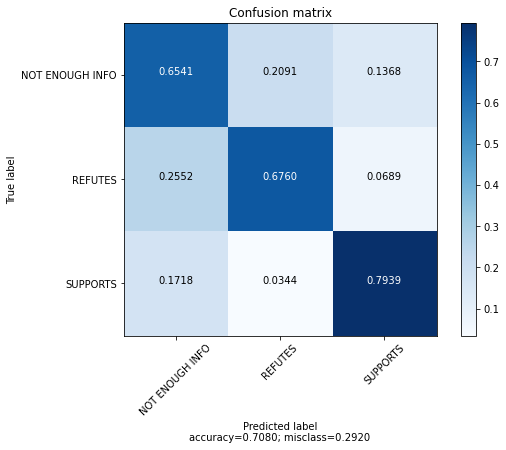

MALON
                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.70      0.69      0.69      6666
        REFUTES       0.82      0.69      0.75      6666
       SUPPORTS       0.75      0.89      0.81      6666

       accuracy                           0.75     19998
      macro avg       0.76      0.75      0.75     19998
   weighted avg       0.76      0.75      0.75     19998



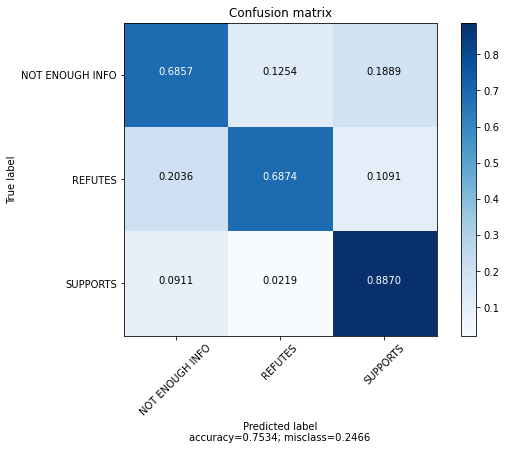

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

for method in methods:
    print(method.upper())
    cr = classification_report(df_with_evidence_scored['label'], df_with_evidence_scored[f'predicted_label_{method}'])
    print(cr)

    cm = confusion_matrix(df_with_evidence_scored['label'], df_with_evidence_scored[f'predicted_label_{method}'])
    plot_confusion_matrix(cm, ['NOT ENOUGH INFO','REFUTES','SUPPORTS'])

# Calculating FEVER Score for DEV set

In [15]:
from fever.scorer import fever_score

In [16]:
SCRATCH = Path('/scratch/k20036346')
gold_file = SCRATCH / 'fever/fever_jsonl/shared_task_dev.jsonl'

gold_data = []
with open(gold_file, 'r') as f:
    for line in f:
        gold_data.append(json.loads(line))
gold_data = pd.DataFrame(gold_data).set_index('id')
df_with_evidence_scored = df_with_evidence_scored.set_index('id').join(gold_data['evidence'], how='outer', rsuffix='_golden').reset_index()
df_with_evidence_scored

,id,evidence,claim,label,predicted_label_WEIGHTED_SUM,predicted_label_MALON,evidence_golden
0,91198,"[[Colin_Kaepernick, 6, He remained the team 's...",Colin Kaepernick became a starting quarterback...,NOT ENOUGH INFO,SUPPORTS,SUPPORTS,"[[[108548, None, None, None]]]"
1,194462,"[[Tilda_Swinton, 0, Katherine Matilda `` Tilda...",Tilda Swinton is a vegan.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[227768, None, None, None]]]"
2,137334,"[[Soul_Food_-LRB-film-RRB-, 0, Soul Food is a ...",Fox 2000 Pictures released the film Soul Food.,SUPPORTS,SUPPORTS,SUPPORTS,"[[[289914, 283015, Soul_Food_-LRB-film-RRB-, 0..."
3,166626,"[[Anne_Rice, 5, Born in New Orleans , Rice spe...",Anne Rice was born in New Jersey.,NOT ENOUGH INFO,REFUTES,REFUTES,"[[[191656, None, None, None], [191657, None, N..."
4,111897,"[[Telemundo, 0, Telemundo LRB LSB teleˈmundo R...",Telemundo is a English-language television net...,REFUTES,REFUTES,REFUTES,"[[[131371, 146144, Telemundo, 0]], [[131371, 1..."
...,...,...,...,...,...,...,...
19993,8538,"[[Hermit_crab, 0, Hermit crabs are decapod cru...",Hermit crabs are arachnids.,REFUTES,REFUTES,REFUTES,"[[[15450, 19262, Hermit_crab, 0], [15450, 1926..."
19994,145641,"[[Michael_Hutchence, 17, In 2000 , Yates died ...",Michael Hutchence died on a boat.,REFUTES,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[168967, 182663, Michael_Hutchence, 15]]]"
19995,87517,"[[Cyclades, 0, The Cyclades LRB LSB ˈsɪklədiːz...",The Cyclades are located to the southeast of G...,SUPPORTS,SUPPORTS,SUPPORTS,"[[[104709, 118125, Cyclades, 0]]]"
19996,111816,"[[Theresa_May, 6, From 1977 until 1983 , she w...",Theresa May worked the docks.,NOT ENOUGH INFO,NOT ENOUGH INFO,NOT ENOUGH INFO,"[[[131223, None, None, None]]]"


In [17]:
predicted = {}
for method in methods:
    predicted[method] = []
    for idx in df_with_evidence_scored.index:
        #print(df_with_evidence_scored.loc[idx],'\n')
        #print(df_with_evidence_scored.loc[idx], '\n')
        instance = {
            'label': df_with_evidence_scored.loc[idx, 'label'],
            'predicted_label': df_with_evidence_scored.loc[idx, f'predicted_label_{method}'],
            'predicted_evidence': [
                [evidence[0], evidence[1]] for evidence in df_with_evidence_scored.loc[idx, 'evidence']
            ],
            'evidence': df_with_evidence_scored.loc[idx, 'evidence_golden'],
        }
        predicted[method].append(instance)
        
        
        #print(instance)
        #break

In [18]:
for method in methods:
    print(method,'\n')
    strict_score, label_accuracy, precision, recall, f1 = fever_score(predicted[method])

    print('strict_score:',strict_score)    
    print('label_accuracy:',label_accuracy)   
    print('precision:',precision) # It's ok if this is bad. It's recall that matters.       
    print('recall:',recall)           
    print('f1:',f1)     
    print()
#strict_score: 0.7549254925492549
#label_accuracy: 0.7563256325632564
#precision: 0.3059355935593105
#recall: 0.9966246624662466
#f1: 0.46815946710641265



WEIGHTED_SUM 

strict_score: 0.6924192419241925
label_accuracy: 0.707970797079708
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454

MALON 

strict_score: 0.733973397339734
label_accuracy: 0.7533753375337534
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454



**STANDARD MODEL FROM 2021**

For the **DEV** set, we have:
```
WEIGHTED_SUM 

strict_score: 0.6898189818981898
label_accuracy: 0.6911691169116911
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265

MALON 

strict_score: 0.7549254925492549
label_accuracy: 0.7563256325632564
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265
```

And for the **EVAL** set (DEV minus the evidence golden data) we have:
```
WEIGHTED_SUM 

strict_score: 0.6842684268426843
label_accuracy: 0.6992699269926993
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454

MALON 

strict_score: 0.729072907290729
label_accuracy: 0.7475747574757475
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454
```

**HYPERPARAMETER SEARCHED MODEL FROM 2021**

For the **DEV** set, we have:
```
strict_score: 0.6999199919992
label_accuracy: 0.7012701270127013
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265

MALON 

strict_score: 0.7623762376237624
label_accuracy: 0.7637763776377637
precision: 0.3059355935593105
recall: 0.9966246624662466
f1: 0.46815946710641265
```

And for the **EVAL** set (DEV minus the evidence golden data) we have:
```
WEIGHTED_SUM 

strict_score: 0.6924192419241925
label_accuracy: 0.707970797079708
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454

MALON 

strict_score: 0.733973397339734
label_accuracy: 0.7533753375337534
precision: 0.27134213421338077
recall: 0.9450945094509451
f1: 0.4216314307258454
```

# Calculating blind score for test set

First, run the cells above but for the TEST set, except for the evaluation cells, as they do not work without the ground-truth labels (The test set does not have any).

In [15]:
for method in methods:

    predicted = []
    for idx in df_with_evidence_scored.index:
        instance = {
            'id': idx,
            'predicted_label': df_with_evidence_scored.loc[idx, f'predicted_label_{method}'],
            'predicted_evidence': [
                [evidence[0], evidence[1]] for evidence in df_with_evidence_scored.loc[idx, 'evidence']
            ]
        }
        predicted.append(instance)
        
    output = f'./data/support_data_v2/blind_submission_bert_test_from_fresh_trained_with_batch_size_32_LABELLED_{method}.jsonl'
    with open(output,'w+') as f:
        for p in predicted:
            f.write(json.dumps(p)+'\n')

References from last year (best model by us, best model by others)

- blind_submission_bert_test_from_fresh_trained_with_batch_size_32_LABELLED
    - FEVER Score: 		0.6739
    - Accuracy: 		0.7037
    - Evidence Precision: 	0.2482
    - Evidence Recall: 	0.87
    - Evidence F1: 		0.3863

- blind_submission_bert_test_LABELLED
    - FEVER Score: 		0.6769
    - Accuracy: 		0.7066
    - Evidence Precision: 	0.2521
    - Evidence Recall: 	0.8747
    - Evidence F1: 		0.3914


For the **TEST** set, we have:
```
WEIGHTED_SUM 

strict_score: 0.617
label_accuracy: 0.6508
precision: 0.2482
recall: 0.87
f1: 0.3863

MALON 

strict_score: 0.6617
label_accuracy: 0.6912
precision: 0.2482
recall: 0.87
f1: 0.3863
```